Author: René Uhliar

Initialize all the imports for the upcoming few blocks. Also set the printoptions, so that when printing numpy data we print everything, instead of just partial data.

In [31]:
from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix
from kaldi.util.options import ParseOptions
from kaldi.util.table import SequentialWaveReader
from kaldi.util.table import MatrixWriter
from sklearn.preprocessing import scale

import numpy as np
np.set_printoptions(threshold=np.inf)

We create a wrapper that will contain all the important data about the Mfcc. We want to have all these data grouped together, so that we can return it from a function and pass it as an argument to a function.

In [32]:
class PreparedMfcc():
    
    def __init__(self, mfcc, mfcc_opts, rspec, wspec, opts, sample_freq):
        self.mfcc = mfcc
        self.mfcc_opts = mfcc_opts
        self.rspec = rspec
        self.wspec = wspec
        self.opts = opts
        self.sample_freq = sample_freq

Here we set all the important data and return them all in the PreparedMfcc wrapper mentioned above. This function initializes a file with KEY VALUE pairs split by a whitespace (space) character.

KEY = A key to the value.
VALUE = A path to the audio file.

In [33]:
def get_prepared_mfcc(scp_file, file_key_value_dict):
    with open(scp_file, "w", newline='\n') as output:
        for key, val in file_key_value_dict.items():
            output.write(key + " " + val + '\n')

    usage = """Extract MFCC features.
               Usage: example.py [opts...] <rspec> <wspec>
            """
    po = ParseOptions(usage)
    po.register_float("min-duration", 0.0, "minimum segment duration")

    mfcc_opts = MfccOptions()
    mfcc_opts.frame_opts.samp_freq = 8000
    mfcc_opts.register(po)

    # parse command-line options
    opts = po.parse_args()
    rspec, wspec = "scp:" + scp_file, "ark,t:" + scp_file + "_mfcc.ark"

    mfcc = Mfcc(mfcc_opts)
    sf = mfcc_opts.frame_opts.samp_freq

    return PreparedMfcc(mfcc, mfcc_opts, rspec, wspec, opts, sf)
    

Standard PyKaldi stuff that I got from (6th code slide) https://github.com/pykaldi/pykaldi/blob/master/examples/notebooks/mfcc-extraction.ipynb
But I have tweaked it a little for our purpose. This basically creates the MFCC features n x n dimensional array, which produces usable data for e.g. plotting.

In [34]:
def create_mfcc_features(prepared_mfcc):
    # Check whether crucial attributes have been set in prapred_mfcc.
    if prepared_mfcc is None:
        raise Exception("prepared_mfcc is None.")
        
    with SequentialWaveReader(prepared_mfcc.rspec) as reader, MatrixWriter(prepared_mfcc.wspec) as writer:
        print(reader)
        my_dict = {}
        for key, wav in reader:
            if wav.duration < prepared_mfcc.opts.min_duration:
                continue

            assert(wav.samp_freq >= prepared_mfcc.sample_freq)
            assert(wav.samp_freq % prepared_mfcc.sample_freq == 0)

            # wav.samp_freq = 10000.0
            print("print(wav.samp_freq) result:")
            print(wav.samp_freq)
            print()

            s = wav.data()
            print("print(s) result:")
            print(s)
            print()
            # 11891 28260 ... 360 362
            # 11772 28442 ... 362 414
            # [kaldi.matrix.Matrix of size 2x23001]

            # downsample to sf [default = 8khz]
            s = s[:,::int(wav.samp_freq / prepared_mfcc.sample_freq)]

            # mix-down stereo to mono
            m = SubVector(np.mean(s, axis=0))

            # compute MFCC features
            f = prepared_mfcc.mfcc.compute_features(m, prepared_mfcc.sample_freq, 1.0)

            # standardize features
            f = SubMatrix(scale(f))
            
            # >>> print(f)
            # -0.8572 -0.6932 ... 0.5191 0.3885
            # -1.3980 -1.0431 ... 1.4374 -0.2232
            # ... ...
            # -1.7816 -1.4714 ... -0.0832 0.5536
            # -1.6886 -1.5556 ... 1.0878 1.1813
            # [kaldi.matrix.SubMatrix of size 142x13]

            # write features to archive

            writer[key] = f
            
            my_dict[key] = f
        return my_dict

Here we initialize a dictionary which contains two paths to audio files and we use that with the function defined above.

In [35]:
audio_files = {"TEST":"/datb/aphasia/languagedata/voorRene.wav", "TEST2":"test_data/nl-0269.wav", "TEST3":"test_data/rene_eeeee.wav"}
prepared_mfcc = get_prepared_mfcc("testfile.scp", audio_files)

Create the MFCC features for the files from the dictionary and print those.

In [36]:
mfcc_features_dict = create_mfcc_features(prepared_mfcc)
print(mfcc_features_dict)

print(wav.samp_freq) result:
16000.0

print(s) result:

   -31    -32    -29  ...      -8     -1     -8
[kaldi.matrix.Matrix of size 1x640936]


print(wav.samp_freq) result:
48000.0

print(s) result:

  -10   -13   -12  ...     63    59    58
[kaldi.matrix.Matrix of size 1x165888]


print(wav.samp_freq) result:
48000.0

print(s) result:

     0      0      0  ...      -5     -9     -7
     0      0      0  ...      -5     -9     -7
[kaldi.matrix.Matrix of size 2x181248]


{'TEST': 
-2.3233e+00 -3.3797e-01  4.4341e-01  ...  -2.4242e-02  8.7524e-01 -1.0059e-01
-1.9515e+00 -4.6290e-01 -3.0757e-01  ...   4.0510e-01  7.0710e-01  2.1005e+00
-1.9265e+00 -4.4229e-01  3.7984e-01  ...   1.7819e-01  9.4712e-01  6.4836e-01
                ...                   ⋱                   ...                
-2.0560e+00 -7.1789e-01  8.6530e-01  ...   2.7970e-01  1.5339e+00  8.0286e-02
-2.0155e+00 -7.8794e-01  6.8534e-01  ...   1.0779e+00  2.0804e-01 -3.2510e-01
-2.4349e+00 -7.0743e-01  8.6904e-01  ...   3.

We extract the features of the file that belongs to the key 'TEST2' and we print the whole Kaldi SubMatrix which is produced in mfcc_features_dict. We also print the first 25 x 13 data from the beginning and 25 x 13 data from the end of the Kaldi SubMatrix.

In [50]:
# print some data to quick peek whether everything is fine
kaldi_wav_data = mfcc_features_dict["TEST3"]
print(kaldi_wav_data)
# first 25 elements
print(kaldi_wav_data[0:25])
# last 25 elements
last_elem = len(kaldi_wav_data) - 1
print(kaldi_wav_data[last_elem - 25:last_elem])


-3.0445  0.2837 -0.4164  ...   1.7214 -0.3328  0.6196
-2.7316 -0.0042 -0.0812  ...   2.5587 -0.4974 -0.2444
-2.8378 -0.1976 -0.3858  ...   1.8237 -1.3205  1.1498
          ...             ⋱             ...          
-0.7280 -1.6382 -0.5093  ...   0.4417  0.8009 -2.5397
-0.6539 -1.3874 -0.1002  ...   1.0842  0.4427 -2.3745
-0.8322 -1.7711  0.1748  ...  -0.3508  0.7145 -3.0645
[kaldi.matrix.SubMatrix of size 376x13]



Columns 0 to 9 
-3.0445  0.2837 -0.4164  1.2183  0.2979 -0.3721  0.2128 -2.1551 -0.5375  0.0440
-2.7316 -0.0042 -0.0812  1.5374 -0.0625  0.0166  0.5123 -1.1657 -0.2066  0.8576
-2.8378 -0.1976 -0.3858  1.8876 -0.0953  0.8109  0.4080 -0.8552 -0.5206  1.1141
-3.0611 -0.5282 -0.5058  3.0521  0.0155  1.2042  0.8254 -1.1990 -0.2428  1.0650
-3.1550 -1.6005 -0.3240  1.8247 -0.2418  0.6027 -0.1660 -0.2245  0.0621 -0.5934
-3.4164 -1.2323 -0.6789  1.8710  0.2919  0.9009 -0.4972 -0.8284  0.0391  0.0811
-3.3913 -1.6571 -0.1827  0.7669  0.1844  0.5873 -0.7293 -1.6585  1.0355  0.3637
-2

Initialize plot stuff and show the MFCC plot of the Kaldi SubMatrix which is first converted to numpy array. In this concrete MFCC plot we can see a plot of me saying "eeeeeeeeeeeeeeeee" into the mic for ~2 seconds. I started at around 1.60  seconds and ended around 3.20. There slightly is a visible pattern that can be seen in the kind of blurred part of the plot in between the mentioned start and end time.

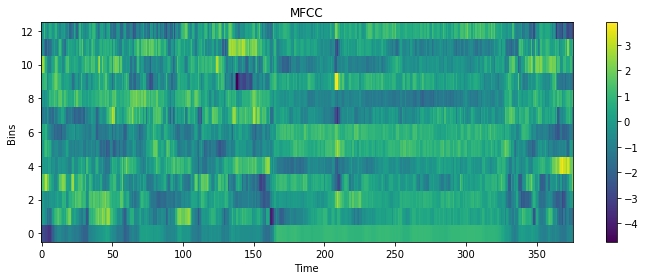

In [51]:
plt.figure(figsize=(10,4))
np_wav_data = np.array(kaldi_wav_data)

# Tanspose the data and set origin to lower, so that Y axis goes from 0 to n, instead of n to 0
plt.imshow(np_wav_data.T, aspect='auto', origin='lower')
plt.colorbar()
plt.title("MFCC")
plt.ylabel("Bins")
plt.xlabel("Time")
plt.tight_layout()
plt.show()